In [1]:
%load_ext autoreload

%autoreload 2

In [541]:
# !pip install -U git+https://github.com/qubvel/efficientnet tensorflow_datasets keras

In [29]:
from efficientnet.keras import EfficientNetB0, EfficientNetB3


input_size = 300
backbone = EfficientNetB3(weights='imagenet')  # or weights='noisy-student'

In [30]:
import tensorflow_datasets as tfds
import tensorflow as tf
import cv2
import numpy as np
from PIL import Image


# tfds.list_builders()

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


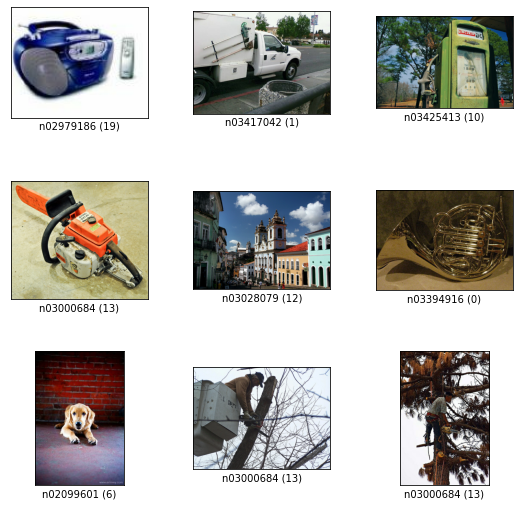

In [956]:
iw_train_ds, iw_train_ds_info = tfds.load('imagewang', split='train', with_info=True)
fig = tfds.show_examples(ds_info, ds)

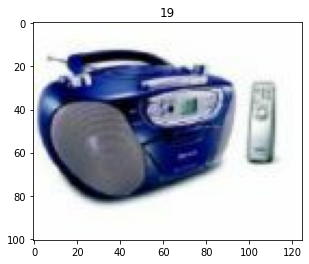

<Figure size 432x288 with 0 Axes>

In [965]:
import os
from glob import glob
from sklearn.utils import shuffle


np.random.seed(101)

dst_dir = './data/flickr'
dst_type = 'train'
labels = 'countryside', 'urban', 'cat', 'selfy', 'dog'

partitions = []

def dataset_files_list_generator(dataset_dir, dataset_type, labels):
    img_paths = []
    img_labels = []
    for label in labels:
        fps = glob(os.path.join(dataset_dir.decode(), f'{dataset_type.decode()}/{label.decode()}/*'))
        img_paths.extend(fps)
        img_labels.extend([label]*len(fps))
        
    img_paths, img_labels = shuffle(img_paths, img_labels)
    for img_path, label in zip(img_paths, img_labels):
        yield tf.constant(img_path, dtype=tf.string), tf.constant(label, dtype=tf.string)

        
def prepare_example(img_fp, label, target_size=(331, 331)):
    img_fp = img_fp.numpy().decode()
    return tf.constant(cv2.resize(cv2.cvtColor(cv2.imread(img_fp), cv2.COLOR_BGR2RGB), target_size), dtype=tf.uint8), tf.constant(label, dtype=tf.string)


def prepare_example_wrap(*args):
    return tf.py_function(prepare_example, inp=args, Tout=(tf.uint8, tf.string))

# flickr_dataset = tf.data.Dataset.from_generator(dataset_files_list_generator, (tf.string, tf.string), args=(dst_dir, dst_type, labels)) \
#                             .map(prepare_example_wrap)
for item in iw_train_ds:
    image, label = item['image'], item['label']
    plt.imshow(image.numpy())
    plt.title(label.numpy())
    plt.figure()
    break


In [978]:
from keras.applications.vgg16 import preprocess_input 
# from keras.applications.nasnet import preprocess_input
from keras.preprocessing.image import load_img

input_size = 224
backbone = tf.keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
# input_size = 331
# backbone = tf.keras.applications.NASNetLarge(
#     input_shape=None,
#     include_top=True,
#     weights="imagenet",
#     input_tensor=None,
#     pooling=None,
#     classes=1000,
# )


In [327]:
# !apt-get update
# !apt-get install ffmpeg libsm6 libxext6  -y

In [981]:
from tensorflow import keras
from efficientnet.preprocessing import center_crop_and_resize, resize

np.random.seed(101)

def preprocess_image(img, target_size=input_size):
    return center_crop_and_resize(img, input_size).astype(np.uint8)


def load_example(fp, target_size=input_size):
    img = Image.open(fp).resize(target_size)
    return np.array(img)


def extract_features(model, img):
    img = tf.constant(cv2.resize(img.numpy().astype(np.uint8), (input_size, input_size)))
    img = preprocess_input(img)
    img = tf.expand_dims(img, axis=0)
    return model.predict(img, use_multiprocessing=True)


model = keras.Model(inputs=backbone.inputs, outputs=backbone.layers[-2].output)
it = iter(dataset)
# f = extract_features(model, next(it)[0])
f = extract_features(model, next(iter(iw_train_ds))['image'])
print(f.shape)
f

(1, 4096)


array([[1.1251066, 0.       , 0.       , ..., 1.7121961, 0.       ,
        4.3010516]], dtype=float32)

In [982]:
%timeit f = extract_features(model, next(it)[0])

139 ms ± 7.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [983]:
img = next(it)[0].numpy()

def color_histogram_features(img):
    hist = cv2.calcHist(images=[img], channels=[0, 1, 2], mask=None, histSize=[8, 8, 8], ranges=[0, 256] * 3)
    hist = cv2.normalize(hist, dst=hist.shape)
    return hist.reshape(1, -1)

hist = color_histogram_features(img)
hist.shape

(1, 512)

In [1000]:
from tqdm.notebook import tqdm


X, y = [], []

for item in tqdm(iw_train_ds):
    image, label = item['image'], item['label']
#     feats = color_histogram_features(image.numpy())
    feats = extract_features(model, image)
    X.append(feats)
    y.append(label.numpy())


In [1001]:
import pandas as pd


df = pd.DataFrame(np.array(X).squeeze())
df['class'] = y
# df['class'] = df['class'].astype('category')
# df['class_id'] = df['class'].cat.codes
df['id'] = df.index
df

0         1         2         3         4         5         6  \
0      1.125107  0.000000  0.000000  6.567400  0.000000  0.482483  0.000000   
1      0.000000  0.000000  0.075374  4.913631  0.000000  0.000000  0.000000   
2      0.000000  0.000000  0.000000  0.000000  0.000000  3.980497  0.000000   
3      0.000000  0.000000  2.015477  0.000000  0.000000  4.919334  0.000000   
4      1.779704  7.493359  0.000000  0.000000  0.576503  4.606519  0.000000   
...         ...       ...       ...       ...       ...       ...       ...   
14664  0.887138  0.262983  0.000000  0.000000  0.000000  0.000000  0.000000   
14665  1.641913  0.000000  2.681962  0.000000  0.000000  0.000000  2.854546   
14666  0.000000  0.000000  0.000000  7.316676  0.000000  0.000000  0.000000   
14667  0.000000  0.000000  3.259276  0.453938  0.000000  0.000000  0.000000   
14668  0.000000  5.752075  0.000000  0.000000  1.655604  0.000000  0.162024   

              7         8         9  ...      4088      4089      4090  4091  \
0      0.894397  0.000000  0.718096  ...  0.000000  0.000000  2.271722   0.0   
1      0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   0.0   
2      0.000000  2.935166  0.000000  ...  4.814053  0.000000  3.837638   0.0   
3      5.647666  4.424227  0.000000  ...  0.000000  0.000000  3.590111   0.0   
4      0.000000  0.472028  0.000000  ...  0.000000  0.000000  0.000000   0.0   
...         ...       ...       ...  ...       ...       ...       ...   ...   
14664  0.000000  5.226455  0.000000  ...  0.000000  0.444135  0.000000   0.0   
14665  0.738350  0.000000  0.712222  ...  0.000000  0.000000  0.000000   0.0   
14666  0.000000  0.000000  0.000000  ...  0.000000  0.000000  3.515201   0.0   
14667  0.000000  0.000000  0.000000  ...  0.734181  0.000000  0.000000   0.0   
14668  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   0.0   

           4092      4093      4094      4095  class     id  
0      0.000000  1.712196  0.000000  4.301052     19      0  
1      0.863581  0.000000  0.000000  1.193176      1      1  
2      0.000000  0.000000  0.000000  1.182008     10      2  
3      0.000000  0.262527  0.000000  7.016220     13      3  
4      2.638256  5.216855  1.117993  0.000000     12      4  
...         ...       ...       ...       ...    ...    ...  
14664  0.000000  0.000000  0.000000  0.811830     13  14664  
14665  0.000000  0.000000  0.000000  0.000000      9  14665  
14666  0.349781  2.875693  0.000000  0.000000      1  14666  
14667  5.885119  2.117824  1.653024  0.166892     12  14667  
14668  0.000000  0.000000  2.832668  0.000000      0  14668  

[14669 rows x 4098 columns]

In [1002]:
from sklearn.cluster import DBSCAN, KMeans, MeanShift
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.decomposition import PCA


X_train, X_test, y_train, y_test = train_test_split(df.drop(['class'], axis=1), df['class'], test_size=0.12, random_state=101)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12908, 4097), (12908,), (1761, 4097), (1761,))

In [1003]:
y_test.value_counts()

9     181
12    181
14    179
10    166
19    166
0     160
1     157
8     151
11    149
13    140
18     17
17     16
3      16
4      15
15     13
7      13
6      13
5      13
2       8
16      7
Name: class, dtype: int64

In [1032]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE


# tsne = TSNE(n_components=2)
# X_train_transformed = tsne.fit_transform(X_train)
# plt.scatter(X_train_transformed[:, 0], X_train_transformed[:, 1], c=y_train)

In [1012]:
from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline


# num_clusters = ds_info.features['label'].num_classes
num_clusters = len(np.unique(y))
print(num_clusters)

def histogram_comparison(h1, h2, method=cv2.HISTCMP_BHATTACHARYYA, bins=(8, 8, 8)):
    return cv2.compareHist(h1.reshape(*bins).astype(np.float32), h2.reshape(*bins).astype(np.float32), method)


clst = Pipeline((
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=0.9)),
    ('model', KMeans(num_clusters, max_iter=3000, random_state=101))
))

# clst = KNeighborsClassifier(metric=histogram_comparison)
# clst = MeanShift(max_iter=3000)
# clst = GaussianMixture(num_clusters, max_iter=1000, random_state=101)

clst.fit(X_train.values[:, :-1], y_train)
clst.steps[1][1].explained_variance_ratio_

20


array([5.76063431e-02, 5.04890013e-02, 4.32402300e-02, ...,
       9.87635660e-05, 9.86045379e-05, 9.85206095e-05])

In [1016]:
y_pred = clst.predict(X_test.values[:, :-1])
acc = accuracy_score(y_test, y_pred)
acc

0.07666098807495741

In [1017]:
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt


def plot_multiple_images(batch, title="", cmap=None, figsize=None, axis='off'):
    N = batch.shape[0]
    sqrtn = int(np.ceil(np.sqrt(N)))

    fig = plt.figure(figsize=figsize or (sqrtn, sqrtn))
    fig.suptitle(title)

    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)
    for i in range(N):
        ax = plt.subplot(gs[i])
        if axis == 'off':
            plt.axis(axis)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
        ax.imshow(batch[i], cmap=cmap)


In [1024]:
img_idxs = X_test.values[:, -1]
imgs = []
for item in iw_train_ds.take(img_idxs.max()+1):
    imgs.append(item['image'].numpy())
#     break

In [1026]:
# imgs = np.array([item['image'] for item in ds.take(img_idxs.max()+1)])[img_idxs.astype(int)]
ord_imgs = np.array(imgs)[img_idxs.astype(int)]

In [1027]:
y_pred = clst.predict(X_test.values[:, :-1])
y_pred

array([10,  7, 19, ...,  1, 13, 14], dtype=int32)

['cat' 'countryside' 'dog' 'selfy' 'urban']
0 16
1 16
2 16
3 16
4 16
5 16
6 16
7 16
8 16
9 16
10 16
11 16
12 16
13 16
14 16
15 16
16 16
17 16
18 16
19 16


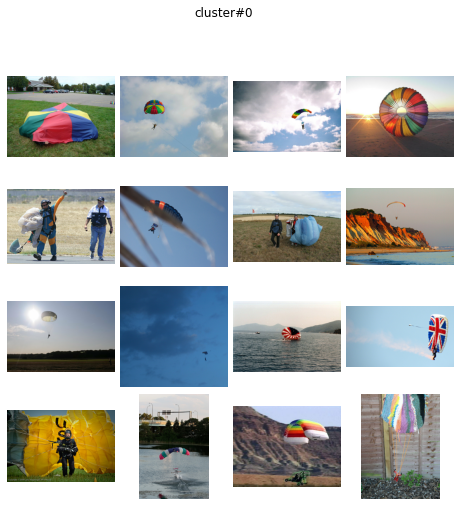

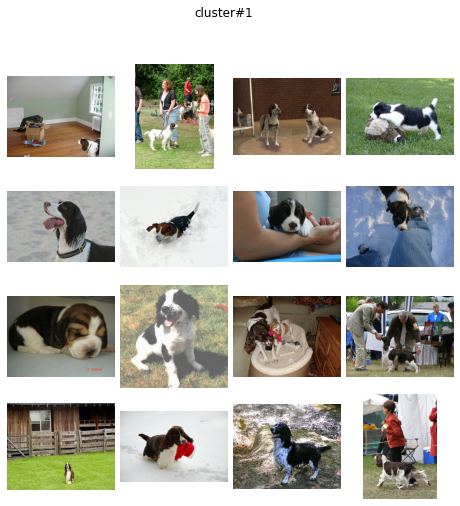

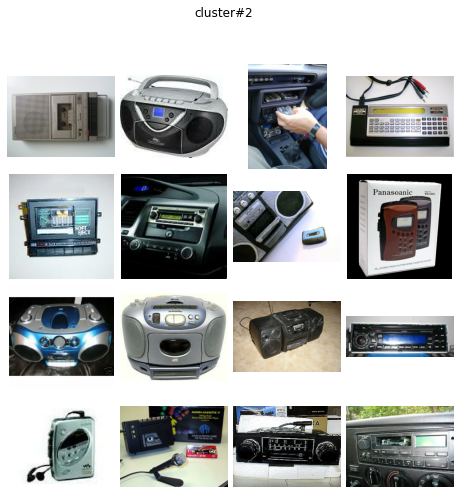

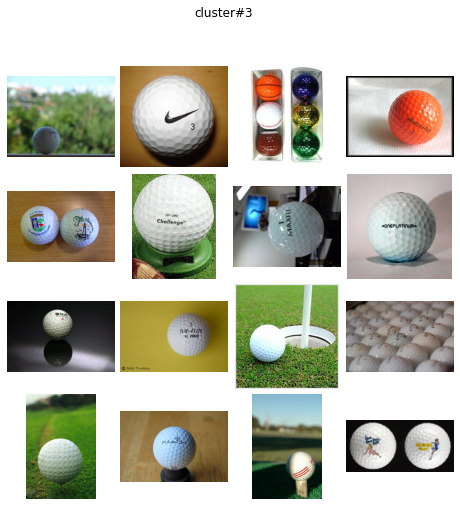

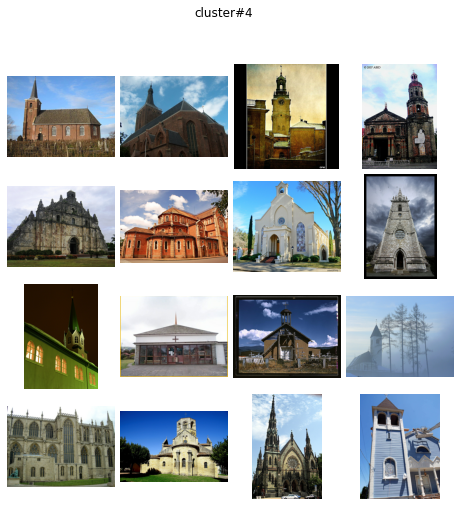

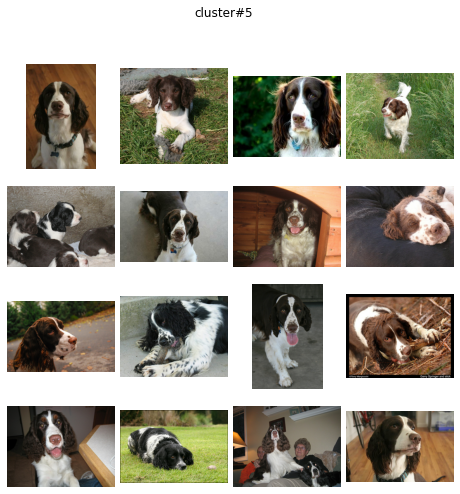

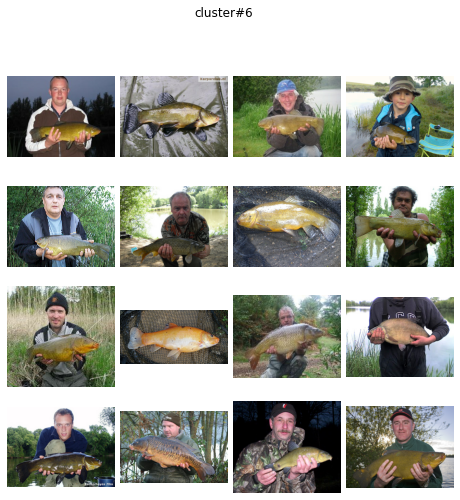

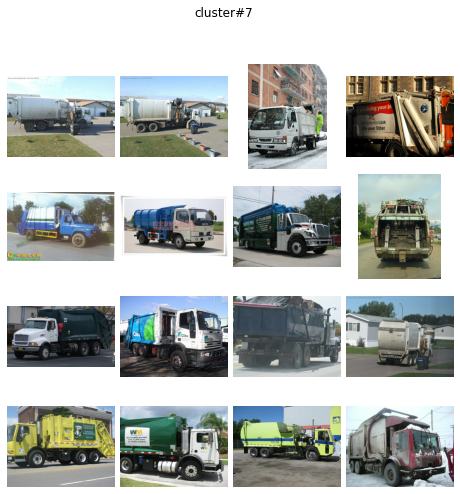

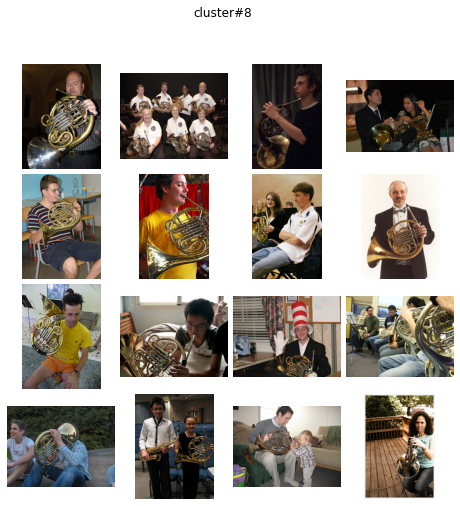

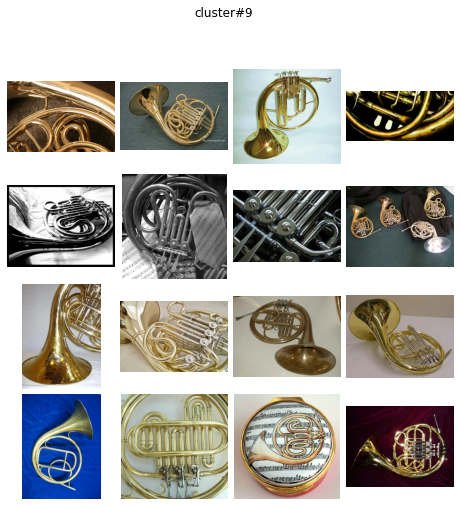

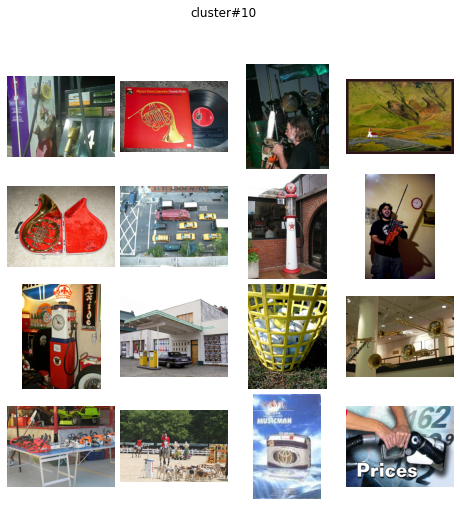

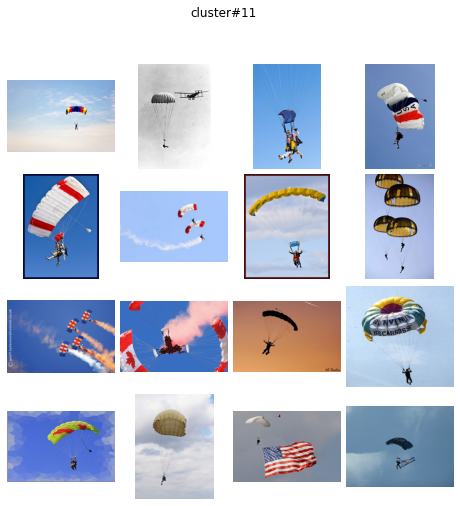

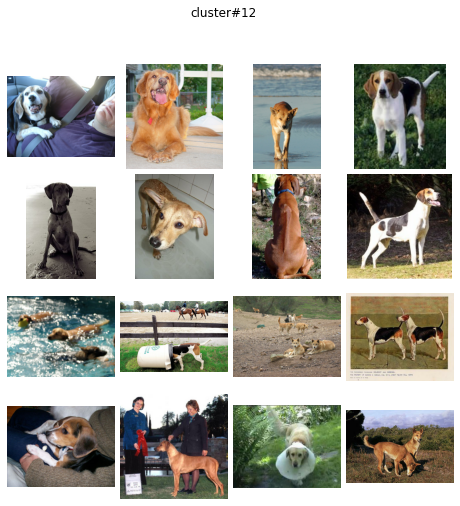

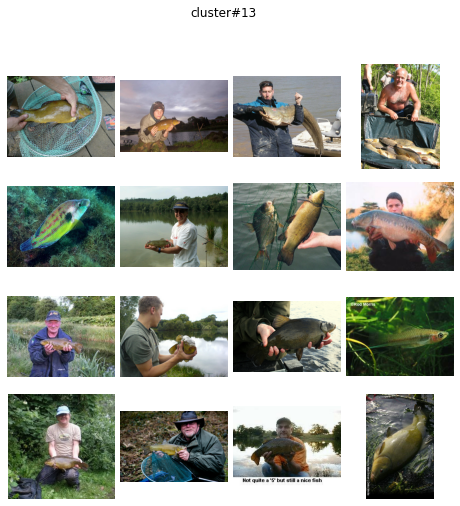

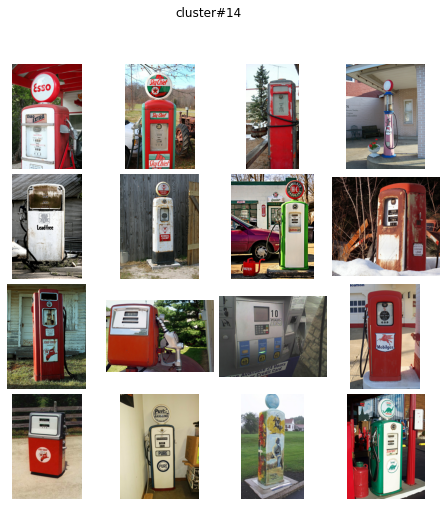

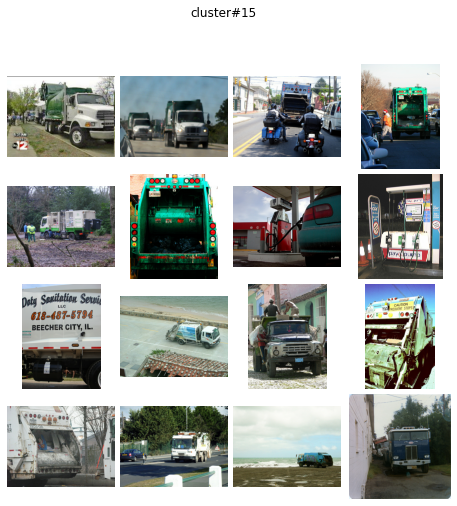

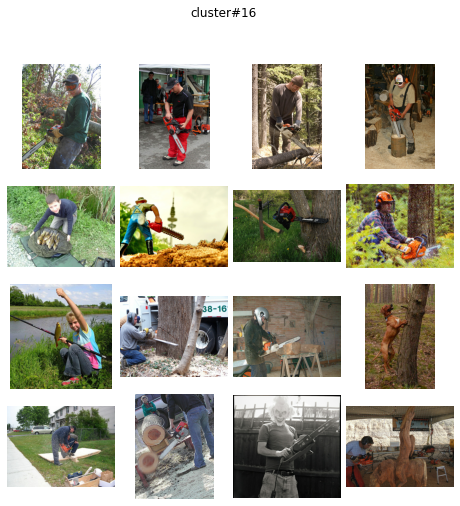

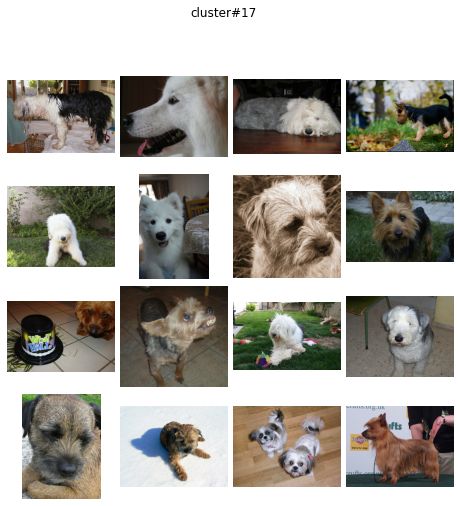

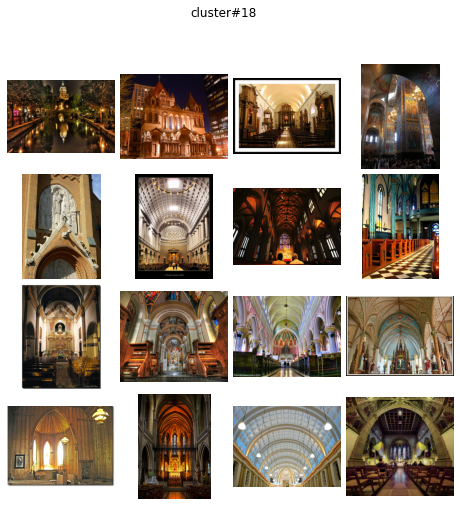

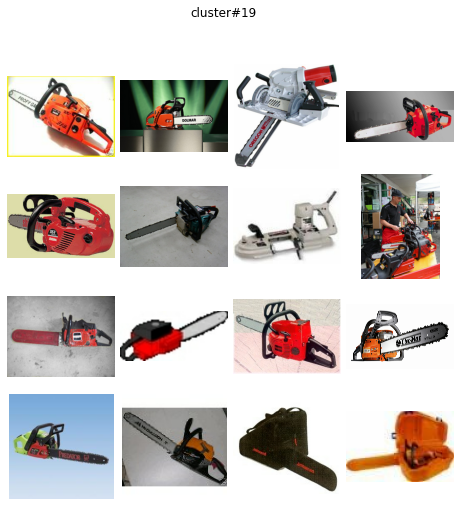

In [1031]:
# cats = df['class'].cat.categories.values
print(cats)
for cluster_id in np.unique(df['class']):
#     cluster_name = cats[cluster_id]
    cluster_images = ord_imgs[y_pred == cluster_id][:16]
    print(cluster_id, len(cluster_images))
    if cluster_images.shape[0] == 0:
        continue
    plot_multiple_images(cluster_images, f'cluster#{cluster_id}', figsize=(8, 8))
#     break